## Classify and count sea lions from image

In [3]:
INPUT_DIR = '../../input/kaggle-sea-lion/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/10/'
MODEL_FILE='../../output/kaggle-sea-lion/03-ok/tf-checkpoint-best9615'

IMAGE_DIMS = (84,84,3)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn

## Initialize cnn classifier

### Prepare output dir

In [5]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-04-27 05:17:16,194 INFO Dir ../../output/kaggle-sea-lion/10/ created


In [6]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]


### Prepare CNN model

In [10]:
logger.info('Prepare CNN for training')
network = cnn.net_medium_lion(IMAGE_DIMS)
model = cnn.prepare_cnn_model(network, OUTPUT_DIR, model_file=MODEL_FILE)

2017-04-27 05:18:00,845 INFO Prepare CNN for training


AttributeError: module 'modules.cnn' has no attribute 'net_medium_lion'

## Look for sea lions present in images

### Perform a sliding window search

## Verify classification/count performance

## Explorations with selective search

In [11]:
import cv2
import matplotlib.pyplot as plt
import skimage.data
import selectivesearch
import modules.utils as utils
import numpy as np

IMAGE_DIMS = (32,32,3)
INPUT_DIR = '../../input/kaggle-sea-lion/'
INPUT_DATASET_NAME = '02/lion-patches-0px'

### Explore known lions image in order to identify key characteristics

2017-04-27 05:18:15,010 INFO showing 20 images
2017-04-27 05:18:15,014 INFO > [started] generating image patches. rows=3; cols=10...


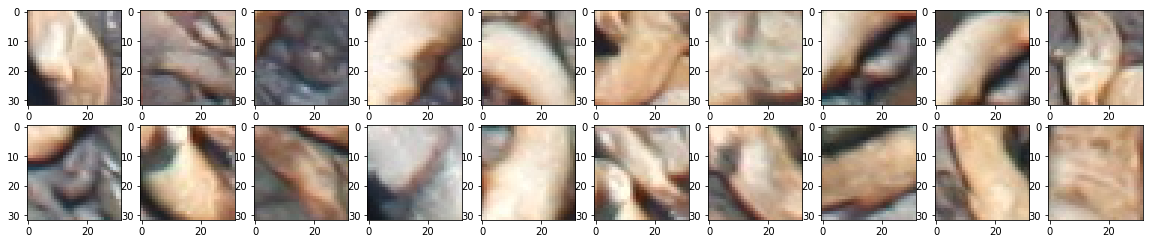

2017-04-27 05:18:17,067 INFO > [done]    generating image patches. rows=3; cols=10 (2053.377 ms)


In [12]:
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
samples = None
with h5py.File(input_dataset_path, 'r') as input_h5:
    samples = input_h5['X'][20:40]
    utils.show_images(samples, cols=10, is_bgr=True, size=2)

## Mask image so only desired lion colors remain

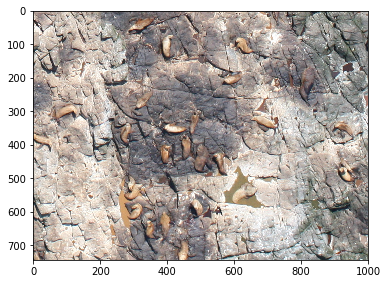

In [85]:
img_file = INPUT_DIR + 'Train/0.jpg'
im0 = cv2.imread(img_file)
im = im0[3000:4000,3000:4000,:]
utils.show_image(im, is_bgr=True)

### Calculage average histogram for random samples

In [86]:
h5file = h5py.File(input_dataset_path, 'r')
xy_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=1)
samples, _ = utils.dump_xy_to_array(xy_generator.flow(), xy_generator.size, x=True, y=False, dtype='uint8', random_skip=0.5)
print(np.shape(samples))
samples_hsv = [cv2.cvtColor(s,cv2.COLOR_BGR2HSV) for s in samples]

2017-04-29 20:26:47,834 INFO > [started] generator dump...


133213/133213

2017-04-29 20:27:37,260 INFO > [done]    generator dump (49425.253 ms)


(67933, 32, 32, 3)


### Perform histogram backpropagation

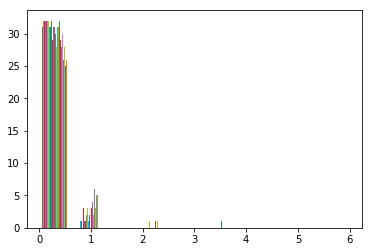

In [87]:
im_hsv = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)

# calculating object histogram
sample_hist = cv2.calcHist(samples_hsv,[0,1], None, [IMAGE_DIMS[0],IMAGE_DIMS[1]], [0, IMAGE_DIMS[0], 0, IMAGE_DIMS[1]])
# sample_hist = cv2.normalize(sample_hist,0,255,cv2.NORM_MINMAX)

plt.hist(sample_hist)

#perform back projection of histogram
s = np.shape(im_hsv)
im_back = cv2.calcBackProject([im_hsv],[0,1],sample_hist,[0,s[0],0,s[1]],1)

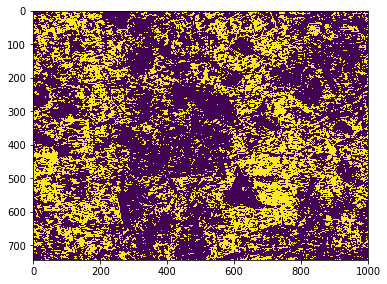

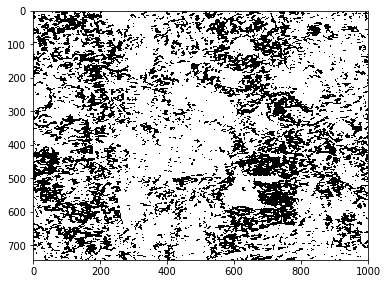

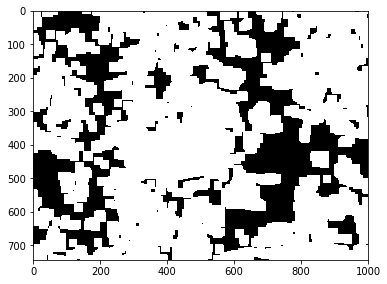

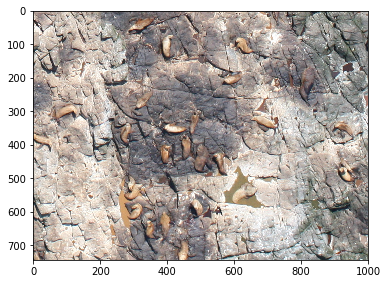

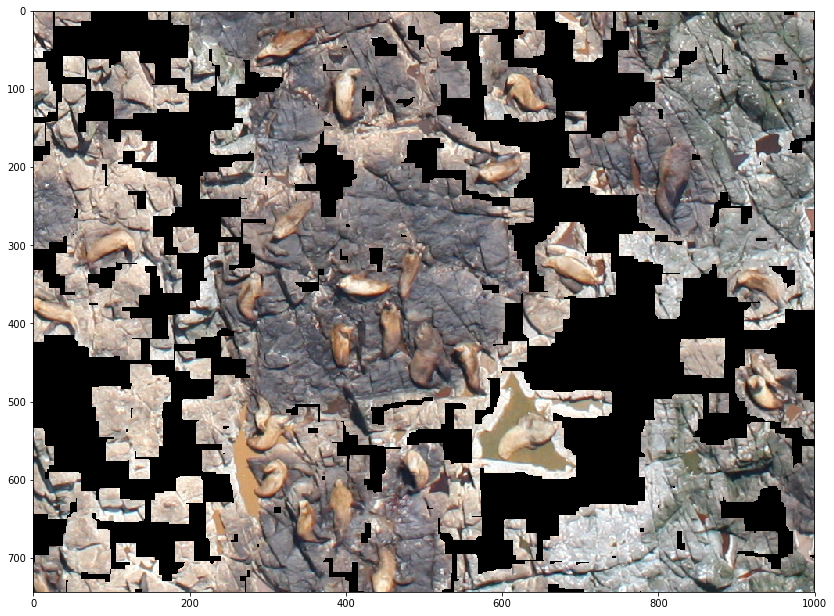

In [88]:
# Now convolute with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
im_back_filter = cv2.filter2D(im_back,-1,disc)

utils.show_image(im_back)

# threshold and binary AND
_,mask = cv2.threshold(im_back_filter,50,255,cv2.THRESH_BINARY_INV)

mask = cv2.merge((mask,mask,mask))
utils.show_image(mask, size=6, is_bgr=True)

kernel = np.ones((3,3),np.uint8)
mask = cv2.erode(mask,kernel,iterations = 5)
mask = cv2.dilate(mask,kernel,iterations = 12)
utils.show_image(mask, size=6, is_bgr=True)

im_masked = cv2.bitwise_and(im_hsv,mask)
im_masked = cv2.cvtColor(im_masked,cv2.COLOR_HSV2BGR)

utils.show_image(im, size=6, is_bgr=True)
utils.show_image(im_masked, size=14, is_bgr=True)


In [89]:
# params = cv2.SimpleBlobDetector_Params()
# params.minThreshold = 150;
# params.maxThreshold = 256;
# params.filterByArea = True
# params.minArea = 10
# params.filterByCircularity = False
# params.minCircularity = 0.1
# params.filterByConvexity = True
# params.minConvexity = 0.5
# params.filterByInertia = False
# params.minInertiaRatio = 0.5
# detector = cv2.SimpleBlobDetector_create(params)
# keypoints = detector.detect(im_masked)

# im_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# utils.show_image(im_keypoints, size=12, is_bgr=True)

### Find candidate areas by Selective Search

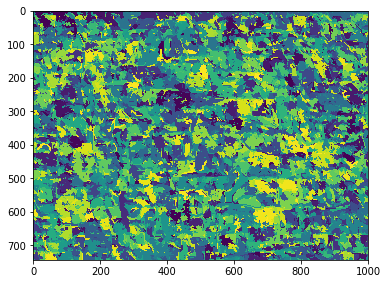

In [90]:
import skimage
regions = skimage.segmentation.felzenszwalb(im, scale=100, sigma=0.5, min_size=10)
utils.show_image(regions, size=6)

In [ ]:
print('selectivesearch')
img_lbl, regions = selectivesearch.selective_search(im_masked, scale=200, sigma=0.8, min_size=20)

print('filtering')
regions2 = []
for a in regions:
    size = a['size']
    r = a['rect']
    regions2 = regions2 + [r]

selectivesearch
filtering


showing
5451
834


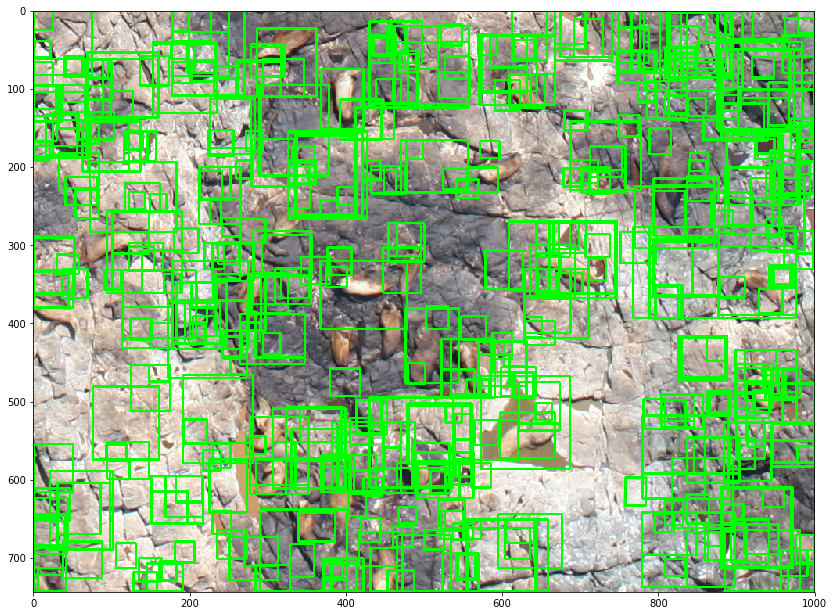

In [ ]:
print('showing')
im2 = im.copy()
print(len(regions2))
count = 0
for r in regions2:
    x, y, w, h = r
    if(w==0 or h==0):
        continue
    if(20<w<120 and 20<h<120 and 0.7<(w/h)<1.3):
        cv2.rectangle(im2, (x, y), (x+w, y+h), (0,255,0), 2)
        count += 1
print(count)
utils.show_image(im2, is_bgr=True, size=14)